# AlphaOracle API Call Demonstration

This note demonstrates the usage of each API in AlphaOracle. It begins by defining common utilities and wrapper functions, and then demonstrates the input and output formats for each task in separate code blocks.

In [1]:
import os
import json
import html
import base64
from pathlib import Path
from typing import Any, Dict, List, Optional, Tuple

import cv2
import numpy as np
import requests

try:
    from IPython.display import HTML, Image, display
except ImportError:
    HTML = None
    Image = None
    def display(*_args, **_kwargs):
        return None
        return None

SERVER_URL = os.getenv("JICHENG_SERVER_URL", "http://vlrlabmonkey.xyz:7680")
DEMO_SAVE_ROOT = Path("outputs")
DEMO_SAVE_ROOT.mkdir(parents=True, exist_ok=True)

TASK_ENDPOINTS: Dict[str, str] = {
    "tapian_danzi_classify": "/tapian_danzi_classify/",
    "moben_danzi_classify": "/moben_danzi_classify/",
    "tapian_danzi_detect": "/tapian_danzi_detect/",
    "moben_danzi_detect": "/moben_danzi_detect/",
    "input_leixing_classify": "/input_leixing_classify/",
    "moben_poyi_classify": "/moben_poyi_classify/",
    "obsd_inference": "/obsd_inference/",
    "p3_inference": "/p3_inference/",
    "evobc_inference": "/evobc_inference/",
    "tapian_juzi_detect": "/tapian_juzi_detect/",
    "get_order_1": "/get_order_1/",
    "dino_search": "/dino_search/",
}

def locate_repo_root() -> Path:
    """向上查找包含 example/images 的目录，兼容不同工作目录"""
    current = Path.cwd().resolve()
    for base in (current, *current.parents):
        if (base / "example" / "images").exists():
            return base
    raise FileNotFoundError("找不到 example/images 目录，请检查项目结构")

REPO_ROOT = locate_repo_root()
IMAGES_DIR = REPO_ROOT / "example" / "images"

DEFAULT_IMAGES: Dict[str, Path] = {
    "moben_danzi_detect": IMAGES_DIR / "h00659.jpg",
    "moben_poyi_classify": IMAGES_DIR / "保.png",
    "input_leixing_classify": IMAGES_DIR / "h00026_190.jpg",
    "tapian_danzi_classify": IMAGES_DIR / "h00026_190.jpg",
    "moben_danzi_classify": IMAGES_DIR / "保.png",
    "tapian_danzi_detect": IMAGES_DIR / "合52拓片.png",
    "tapian_juzi_detect": IMAGES_DIR / "合52拓片.png",
    "obsd_inference": IMAGES_DIR / "保.png",
    "p3_inference": IMAGES_DIR / "保.png",
    "evobc_inference": IMAGES_DIR / "保.png",
    "get_order_1": IMAGES_DIR / "保.png",  # 占位图像，不会真正用到
    "dino_search": IMAGES_DIR / "安.png",
}


In [2]:
def encode_image_to_base64(image_path) -> str:
    image_path = Path(image_path)
    with image_path.open("rb") as f:
        return base64.b64encode(f.read()).decode("utf-8")


def decode_base64_to_image(image_b64: str) -> np.ndarray:
    image_bytes = base64.b64decode(image_b64)
    array = np.frombuffer(image_bytes, dtype=np.uint8)
    return cv2.imdecode(array, cv2.IMREAD_COLOR)


def render_image_gallery(items: List[Dict[str, Any]], *, max_height: int = 320, max_width: Optional[int] = None) -> None:
    if Image is None or HTML is None:
        return
    container_style = "display:flex; flex-wrap:wrap; gap:12px; align-items:flex-start;"
    figure_style = "display:flex; flex-direction:column; align-items:center;"
    img_style_parts = [f"max-height:{max_height}px;"]
    if max_width is not None:
        img_style_parts.append(f"max-width:{max_width}px;")
    img_style = " ".join(img_style_parts)
    figures = []
    for item in items:
        caption = html.escape(str(item.get("caption", "")))
        if item.get("base64"):
            src = f"data:image/png;base64,{item['base64']}"
        elif item.get("path"):
            src = str(Path(item["path"]))
        else:
            continue
        figure_html = (
            f'<div style="{figure_style}">'
            f'<img src="{src}" style="{img_style}" />'
            f'<span style="margin-top:4px; font-size:12px; color:#555;">{caption}</span>'
            f'</div>'
        )
        figures.append(figure_html)
    if not figures:
        return
    gallery_html = f'<div style="{container_style}">{"".join(figures)}</div>'
    display(HTML(gallery_html))


def display_inline_image(*, image_bytes: Optional[bytes] = None, image_path: Optional[Path] = None, caption: Optional[str] = None) -> None:
    if Image is None:
        return
    items: List[Dict[str, Any]] = []
    if image_bytes is not None:
        items.append({"base64": base64.b64encode(image_bytes).decode("utf-8"), "caption": caption})
    elif image_path is not None:
        items.append({"path": Path(image_path), "caption": caption})
    if items:
        render_image_gallery(items)


def save_base64_image(img_base64: str, save_path, *, show_inline: bool = True) -> Path:
    save_path = Path(save_path)
    image = decode_base64_to_image(img_base64)
    save_path.parent.mkdir(parents=True, exist_ok=True)
    cv2.imwrite(str(save_path), image)
    # print(f"✅ 已保存生成图片: {save_path}")
    if show_inline:
        display_inline_image(image_bytes=base64.b64decode(img_base64), caption=save_path.name)
    return save_path


def draw_and_save_boxes(image_path, bboxes, save_path, color=(0, 255, 0), thickness: int = 2) -> Path:
    image_path = Path(image_path)
    image = cv2.imread(str(image_path))
    if image is None:
        raise FileNotFoundError(f"无法读取图片: {image_path}")
    for box in bboxes or []:
        x1, y1, x2, y2 = map(int, box)
        cv2.rectangle(image, (x1, y1), (x2, y2), color, thickness)
    save_path = Path(save_path)
    save_path.parent.mkdir(parents=True, exist_ok=True)
    cv2.imwrite(str(save_path), image)
    print(f"✅ 检测框已绘制: {save_path}")
    display_inline_image(image_path=save_path)
    return save_path


def post_json(session: requests.Session, server_url: str, endpoint: str, payload: Dict[str, Any], *, timeout: int = 60) -> Dict[str, Any]:
    url = f"{server_url.rstrip('/')}{endpoint}"
    response = session.post(url, json=payload, timeout=timeout)
    try:
        response.raise_for_status()
    except requests.HTTPError as exc:
        snippet = response.text[:500]
        raise RuntimeError(f"API 调用失败: {response.status_code} {snippet}") from exc
    return response.json()


def preview_json(data: Any, limit: int = 600) -> str:
    text = json.dumps(data, ensure_ascii=False)
    if len(text) <= limit:
        return text
    return text[:limit] + "..."


In [3]:
session = requests.Session()
session.headers.update({"User-Agent": "AlphaOracle Notebook Demo"})
session


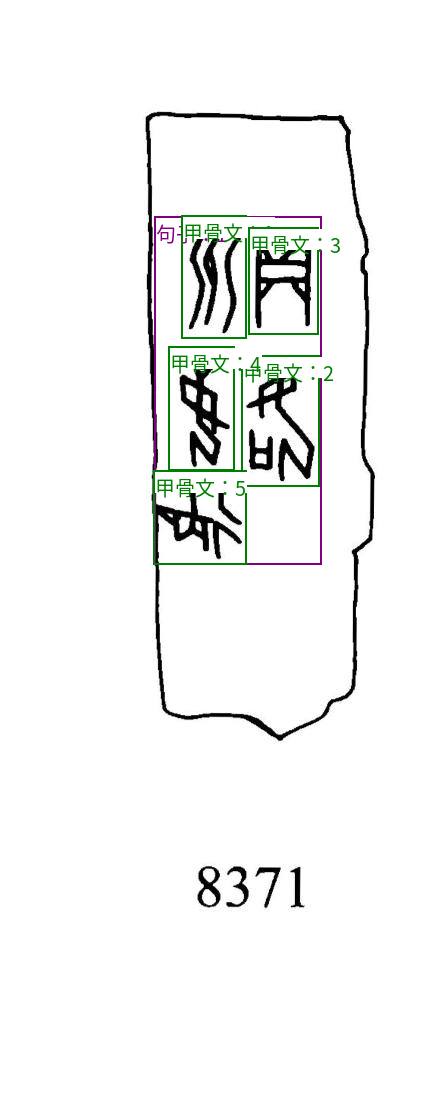
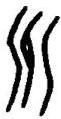
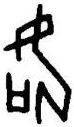
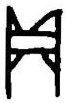
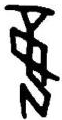
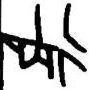

{'input': {'endpoint': '/moben_danzi_detect/',
  'image_path': '/home/user/hsguan/AlphaOracle/example/images/h00659.jpg',
  'save_dir': 'outputs/moben_danzi_detect'},
 'output_preview': '{"results": {"labels": [0, 1, 1, 1, 1, 1], "scores": [0.8802669048309326, 0.8159787058830261, 0.808892548084259, 0.8069634437561035, 0.7910376191139221, 0.6870967149734497], "bboxes": [[156.93382263183594, 218.14273071289062, 319.2207336425781, 562.52294921875], [183.74276733398438, 217.8848419189453, 244.74896240234375, 336.357421875], [243.54965209960938, 357.5270080566406, 317.7394104003906, 484.8737487792969], [250.78306579589844, 229.22450256347656, 316.93695068359375, 332.49505615234375], [170.77084350585938, 348.10882568359375, 232.5313262939453, 468.86236572265625], [155.3197021484375,...'}

In [4]:
def persist_detection_artifacts(response: Dict[str, Any], save_dir) -> List[Path]:
    save_dir = Path(save_dir)
    save_dir.mkdir(parents=True, exist_ok=True)
    saved_paths: List[Path] = []
    gallery_items: List[Dict[str, Any]] = []

    viz_b64 = response.get("image")
    if viz_b64:
        saved_paths.append(save_base64_image(viz_b64, save_dir / "output_with_boxes.png", show_inline=False))
        gallery_items.append({"base64": viz_b64, "caption": "output_with_boxes.png"})

    for idx, crop_b64 in enumerate(response.get("cropped_jgw_images") or [], start=1):
        filename = f"jgw_crop_{idx:02d}.png"
        saved_paths.append(save_base64_image(crop_b64, save_dir / filename, show_inline=False))
        gallery_items.append({"base64": crop_b64, "caption": filename})

    if gallery_items:
        render_image_gallery(gallery_items)

    return saved_paths


def run_moben_danzi_detect(
    session: requests.Session,
    server_url: str,
    image_path,
    *,
    save_root=DEMO_SAVE_ROOT,
    timeout: int = 90,
) -> Tuple[Dict[str, Any], List[Path]]:
    endpoint = TASK_ENDPOINTS["moben_danzi_detect"]
    payload = {"image": encode_image_to_base64(image_path)}
    response = post_json(session, server_url, endpoint, payload, timeout=timeout)
    save_dir = Path(save_root) / "moben_danzi_detect"
    saved_paths = persist_detection_artifacts(response, save_dir)
    return response, saved_paths


task = "moben_danzi_detect"
image_path = DEFAULT_IMAGES[task]

response, saved_paths = run_moben_danzi_detect(
    session=session,
    server_url=SERVER_URL,
    image_path=image_path,
    save_root=DEMO_SAVE_ROOT,
    timeout=90,
)

{
    "input": {
        "endpoint": TASK_ENDPOINTS[task],
        "image_path": str(image_path),
        "save_dir": str(DEMO_SAVE_ROOT / task),
    },
    "output_preview": preview_json(response),
}


In [5]:
def run_moben_poyi_classify(
    session: requests.Session,
    server_url: str,
    image_path,
    *,
    timeout: int = 60,
) -> Dict[str, Any]:
    endpoint = TASK_ENDPOINTS["moben_poyi_classify"]
    payload = {"image": encode_image_to_base64(image_path)}
    return post_json(session, server_url, endpoint, payload, timeout=timeout)


task = "moben_poyi_classify"
image_path = DEFAULT_IMAGES[task]
response = run_moben_poyi_classify(
    session=session,
    server_url=SERVER_URL,
    image_path=image_path,
    timeout=60,
)
{
    "input": {
        "endpoint": TASK_ENDPOINTS[task],
        "image_path": str(image_path),
    },
    "output_preview": preview_json(response),
}


{'input': {'endpoint': '/moben_poyi_classify/',
  'image_path': '/home/user/hsguan/AlphaOracle/example/images/保.png'},
 'output_preview': '[{"pred_class": "已破译", "pred_score": 0.950579047203064}]'}

In [6]:
def run_input_leixing_classify(
    session: requests.Session,
    server_url: str,
    image_path,
    *,
    timeout: int = 60,
) -> Dict[str, Any]:
    endpoint = TASK_ENDPOINTS["input_leixing_classify"]
    payload = {"image": encode_image_to_base64(image_path)}
    return post_json(session, server_url, endpoint, payload, timeout=timeout)


task = "input_leixing_classify"
image_path = DEFAULT_IMAGES[task]
response = run_input_leixing_classify(
    session=session,
    server_url=SERVER_URL,
    image_path=image_path,
    timeout=60,
)
{
    "input": {
        "endpoint": TASK_ENDPOINTS[task],
        "image_path": str(image_path),
    },
    "output_preview": preview_json(response),
}


{'input': {'endpoint': '/input_leixing_classify/',
  'image_path': '/home/user/hsguan/AlphaOracle/example/images/h00026_190.jpg'},
 'output_preview': '{"pred_class": "tapian_single"}'}

In [7]:
def run_tapian_danzi_classify(
    session: requests.Session,
    server_url: str,
    image_path,
    *,
    timeout: int = 60,
) -> Dict[str, Any]:
    endpoint = TASK_ENDPOINTS["tapian_danzi_classify"]
    payload = {"image": encode_image_to_base64(image_path)}
    return post_json(session, server_url, endpoint, payload, timeout=timeout)


task = "tapian_danzi_classify"
image_path = DEFAULT_IMAGES[task]
response = run_tapian_danzi_classify(
    session=session,
    server_url=SERVER_URL,
    image_path=image_path,
    timeout=60,
)
{
    "input": {
        "endpoint": TASK_ENDPOINTS[task],
        "image_path": str(image_path),
    },
    "output_preview": preview_json(response),
}


{'input': {'endpoint': '/tapian_danzi_classify/',
  'image_path': '/home/user/hsguan/AlphaOracle/example/images/h00026_190.jpg'},
 'output_preview': '[{"Rank": 1, "Category": "日", "Possibility": 0.46337810158729553}, {"Rank": 2, "Category": "丁", "Possibility": 0.3821927309036255}, {"Rank": 3, "Category": "亘", "Possibility": 0.11380591243505478}, {"Rank": 4, "Category": "㘡", "Possibility": 0.021759839728474617}, {"Rank": 5, "Category": "田", "Possibility": 0.008967848494648933}, {"Rank": 6, "Category": "多", "Possibility": 0.003053926397114992}, {"Rank": 7, "Category": "王", "Possibility": 0.002752144355326891}, {"Rank": 8, "Category": "雨", "Possibility": 0.00035990567994304}, {"Rank": 9, "Category": "工", "Possibility": 0.00016965392569545656},...'}

In [8]:
def run_moben_danzi_classify(
    session: requests.Session,
    server_url: str,
    image_path,
    *,
    timeout: int = 60,
) -> Dict[str, Any]:
    endpoint = TASK_ENDPOINTS["moben_danzi_classify"]
    payload = {"image": encode_image_to_base64(image_path)}
    return post_json(session, server_url, endpoint, payload, timeout=timeout)


task = "moben_danzi_classify"
image_path = DEFAULT_IMAGES[task]
response = run_moben_danzi_classify(
    session=session,
    server_url=SERVER_URL,
    image_path=image_path,
    timeout=60,
)
{
    "input": {
        "endpoint": TASK_ENDPOINTS[task],
        "image_path": str(image_path),
    },
    "output_preview": preview_json(response),
}


{'input': {'endpoint': '/moben_danzi_classify/',
  'image_path': '/home/user/hsguan/AlphaOracle/example/images/保.png'},
 'output_preview': '[{"Rank": 1, "Category": "保", "Possibility": 0.9248040318489075}, {"Rank": 2, "Category": "yhwcwu1uot", "Possibility": 0.00019883089407812804}, {"Rank": 3, "Category": "好", "Possibility": 0.00014321539492812008}]'}


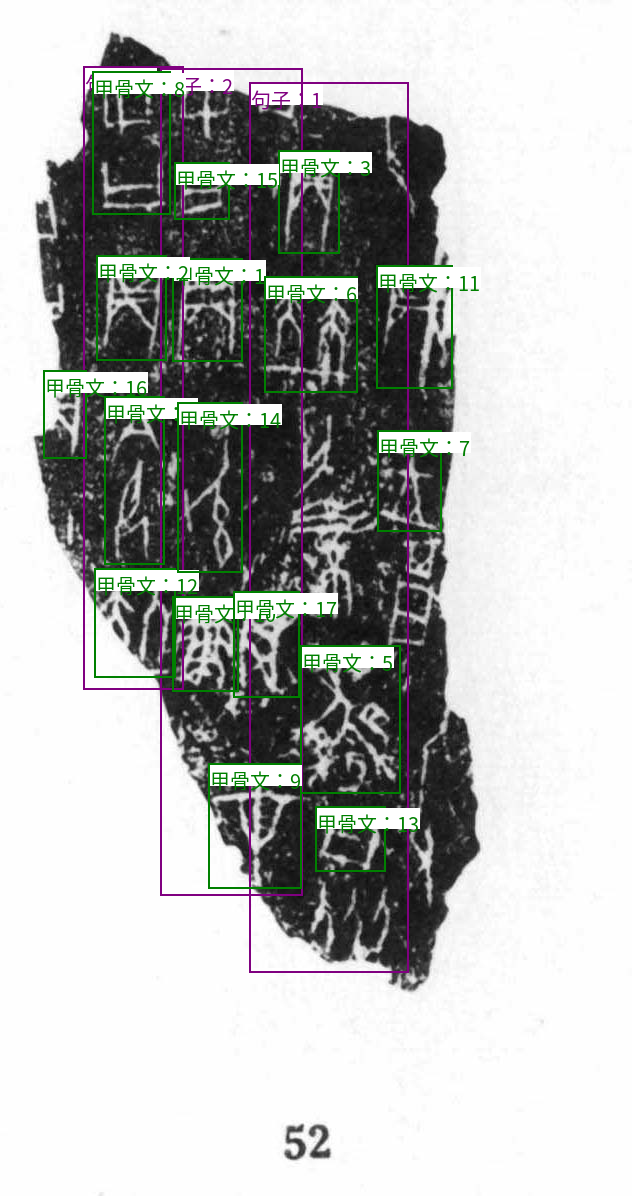
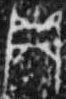
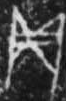
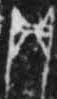
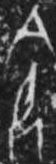
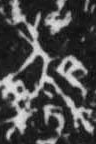
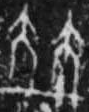
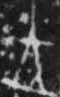
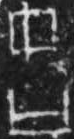
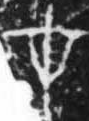
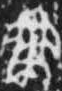
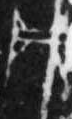
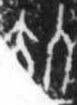
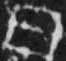
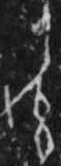
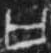
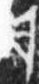
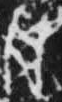

{'input': {'endpoint': '/tapian_danzi_detect/',
  'image_path': '/home/user/hsguan/AlphaOracle/example/images/合52拓片.png',
  'save_dir': 'outputs/tapian_danzi_detect'},
 'output_preview': '{"results": {"labels": [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0], "scores": [0.7738823890686035, 0.7525408267974854, 0.7377829551696777, 0.7096779346466064, 0.6950685381889343, 0.6651231050491333, 0.648435115814209, 0.6234171986579895, 0.6113713383674622, 0.5961110591888428, 0.579500675201416, 0.5509491562843323, 0.5483158230781555, 0.5263086557388306, 0.5157555937767029, 0.5146328210830688, 0.5128906965255737, 0.6006025075912476, 0.5529813170433044, 0.537428081035614], "bboxes": [[174.42803955078125, 260.22552490234375, 240.94728088378906, 359.85382080078125], [98.822540283...'}

In [9]:
def run_tapian_danzi_detect(
    session: requests.Session,
    server_url: str,
    image_path,
    *,
    save_root=DEMO_SAVE_ROOT,
    timeout: int = 90,
) -> Tuple[Dict[str, Any], List[Path]]:
    endpoint = TASK_ENDPOINTS["tapian_danzi_detect"]
    payload = {"image": encode_image_to_base64(image_path)}
    response = post_json(session, server_url, endpoint, payload, timeout=timeout)
    save_dir = Path(save_root) / "tapian_danzi_detect"
    saved_paths = persist_detection_artifacts(response, save_dir)
    return response, saved_paths


task = "tapian_danzi_detect"
image_path = DEFAULT_IMAGES[task]
response, saved_paths = run_tapian_danzi_detect(
    session=session,
    server_url=SERVER_URL,
    image_path=image_path,
    save_root=DEMO_SAVE_ROOT,
    timeout=90,
)
{
    "input": {
        "endpoint": TASK_ENDPOINTS[task],
        "image_path": str(image_path),
        "save_dir": str(DEMO_SAVE_ROOT / task),
    },
    "output_preview": preview_json(response),
}



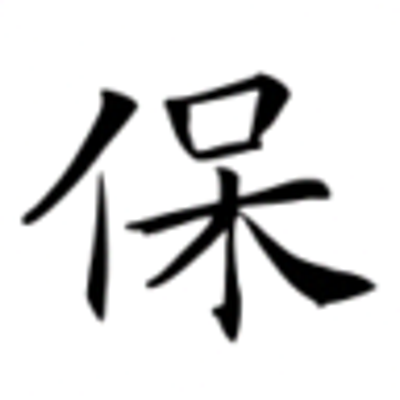

{'input': {'endpoint': '/obsd_inference/',
  'image_path': '/home/user/hsguan/AlphaOracle/example/images/保.png',
  'save_dir': 'outputs/obsd_inference'},
 'output_preview': '{"results": {"final_results": [{"Category": "保", "Possibility": 0.8447446823120117}, {"Category": "㷛", "Possibility": 0.0006678893114440143}, {"Category": "俕", "Possibility": 0.00022701683337800205}, {"Category": "偘", "Possibility": 0.00018730970623437315}, {"Category": "倨", "Possibility": 0.00015510819503106177}, {"Category": "杘", "Possibility": 0.00015507446369156241}, {"Category": "僺", "Possibility": 0.00015413643268402666}, {"Category": "㙅", "Possibility": 0.00013380371092353016}, {"Category": "促", "Possibility": 0.0001318472932325676}, {"Category": "堡", "Possibility": 0.000120329030323773...'}

In [10]:
def run_obsd_inference(
    session: requests.Session,
    server_url: str,
    image_path,
    *,
    save_root=DEMO_SAVE_ROOT,
    timeout: int = 60,
) -> Tuple[Dict[str, Any], List[Path]]:
    endpoint = TASK_ENDPOINTS["obsd_inference"]
    payload = {"image": encode_image_to_base64(image_path)}
    response = post_json(session, server_url, endpoint, payload, timeout=timeout)
    save_dir = Path(save_root) / "obsd_inference"
    saved_paths: List[Path] = []
    font_img_b64 = response.get("results", {}).get("font_img")
    if font_img_b64:
        saved_paths.append(save_base64_image(font_img_b64, save_dir / "font_img.png"))
    return response, saved_paths


task = "obsd_inference"
image_path = DEFAULT_IMAGES[task]
response, saved_paths = run_obsd_inference(
    session=session,
    server_url=SERVER_URL,
    image_path=image_path,
    save_root=DEMO_SAVE_ROOT,
    timeout=60,
)
{
    "input": {
        "endpoint": TASK_ENDPOINTS[task],
        "image_path": str(image_path),
        "save_dir": str(DEMO_SAVE_ROOT / task),
    },
    "output_preview": preview_json(response),
}


In [11]:
def run_p3_inference(
    session: requests.Session,
    server_url: str,
    image_path,
    *,
    timeout: int = 60,
) -> Dict[str, Any]:
    endpoint = TASK_ENDPOINTS["p3_inference"]
    payload = {"image": encode_image_to_base64(image_path)}
    return post_json(session, server_url, endpoint, payload, timeout=timeout)


task = "p3_inference"
image_path = DEFAULT_IMAGES[task]
response = run_p3_inference(
    session=session,
    server_url=SERVER_URL,
    image_path=image_path,
    timeout=60,
)
{
    "input": {
        "endpoint": TASK_ENDPOINTS[task],
        "image_path": str(image_path),
    },
    "output_preview": preview_json(response),
}


{'input': {'endpoint': '/p3_inference/',
  'image_path': '/home/user/hsguan/AlphaOracle/example/images/保.png'},
 'output_preview': '{"final_results": [{"Rank": 1, "Category": "保", "Possibility": 0.9999998807907104}, {"Rank": 2, "Category": "仔", "Possibility": 1.2666590976095904e-07}, {"Rank": 3, "Category": "𠈃", "Possibility": 3.410105748127834e-12}, {"Rank": 4, "Category": "俘", "Possibility": 2.2619957122660406e-12}, {"Rank": 5, "Category": "偒", "Possibility": 2.2118990666841754e-12}, {"Rank": 6, "Category": "𠍙", "Possibility": 4.80091552450268e-13}, {"Rank": 7, "Category": "𠋾", "Possibility": 4.3291417542792865e-13}, {"Rank": 8, "Category": "序", "Possibility": 2.0782663513307237e-13}, {"Rank": 9, "Category": "廟", "Possib...'}

In [12]:
def run_evobc_inference(
    session: requests.Session,
    server_url: str,
    image_path,
    *,
    timeout: int = 60,
) -> Dict[str, Any]:
    endpoint = TASK_ENDPOINTS["evobc_inference"]
    payload = {"image": encode_image_to_base64(image_path)}
    return post_json(session, server_url, endpoint, payload, timeout=timeout)


task = "evobc_inference"
image_path = DEFAULT_IMAGES[task]
response = run_evobc_inference(
    session=session,
    server_url=SERVER_URL,
    image_path=image_path,
    timeout=60,
)
{
    "input": {
        "endpoint": TASK_ENDPOINTS[task],
        "image_path": str(image_path),
    },
    "output_preview": preview_json(response),
}


{'input': {'endpoint': '/evobc_inference/',
  'image_path': '/home/user/hsguan/AlphaOracle/example/images/保.png'},
 'output_preview': '{"results": {"final_results": [{"Rank": 1, "Category": "保", "Possibility": 0.9319777488708496}, {"Rank": 2, "Category": "呆", "Possibility": 0.0007328524370677769}, {"Rank": 3, "Category": "子", "Possibility": 0.0005047409213148057}, {"Rank": 4, "Category": "俔", "Possibility": 0.00011064342106692493}, {"Rank": 5, "Category": "孔", "Possibility": 0.00010223177378065884}, {"Rank": 6, "Category": "好", "Possibility": 7.302323501789942e-05}, {"Rank": 7, "Category": "屖", "Possibility": 6.272434256970882e-05}, {"Rank": 8, "Category": "孟", "Possibility": 6.23232263023965e-05}, {"Rank": 9, "Category": "宗"...'}

In [13]:
def build_order_payload(col_threshold: float = 0.07) -> Dict[str, Any]:
    categories = [1103, 966, 1540, 729, 914, 1006, 496, 336]
    positions = [
        [0.315, 0.352, 0.092, 0.045],
        [0.305, 0.417, 0.087, 0.088],
        [0.296, 0.489, 0.084, 0.079],
        [0.312, 0.569, 0.117, 0.109],
        [0.391, 0.373, 0.104, 0.078],
        [0.435, 0.523, 0.092, 0.139],
        [0.501, 0.372, 0.104, 0.126],
        [0.516, 0.545, 0.139, 0.120],
    ]
    return {
        "categories": categories,
        "positions": positions,
        "col_threshold": col_threshold,
    }


def call_get_order_1(session: requests.Session, server_url: str, payload: Optional[Dict[str, Any]] = None, *, col_threshold: float = 0.07, timeout: int = 60) -> Dict[str, Any]:
    if payload is None:
        payload = build_order_payload(col_threshold=col_threshold)
    endpoint = TASK_ENDPOINTS["get_order_1"]
    return post_json(session, server_url, endpoint, payload, timeout=timeout)

payload = build_order_payload(col_threshold=0.07)
response = call_get_order_1(
    session=session,
    server_url=SERVER_URL,
    payload=payload,
    timeout=90,
)
{
    "input": {
        "endpoint": TASK_ENDPOINTS["get_order_1"],
        "payload": payload,
    },
    "output_preview": preview_json(response),
}

{'input': {'endpoint': '/get_order_1/',
  'payload': {'categories': [1103, 966, 1540, 729, 914, 1006, 496, 336],
   'positions': [[0.315, 0.352, 0.092, 0.045],
    [0.305, 0.417, 0.087, 0.088],
    [0.296, 0.489, 0.084, 0.079],
    [0.312, 0.569, 0.117, 0.109],
    [0.391, 0.373, 0.104, 0.078],
    [0.435, 0.523, 0.092, 0.139],
    [0.501, 0.372, 0.104, 0.126],
    [0.516, 0.545, 0.139, 0.12]],
   'col_threshold': 0.07}},
 'output_preview': '{"sorted_indices": [0, 1, 2, 3, 4, 5, 6, 7], "sorted_categories": [1103, 966, 1540, 729, 914, 1006, 496, 336]}'}

In [14]:
def run_dino_search(
    session: requests.Session,
    server_url: str,
    image_path,
    *,
    timeout: int = 60,
) -> Dict[str, Any]:
    endpoint = TASK_ENDPOINTS["dino_search"]
    payload = {"image": encode_image_to_base64(image_path)}
    return post_json(session, server_url, endpoint, payload, timeout=timeout)


task = "dino_search"
image_path = DEFAULT_IMAGES[task]
response = run_dino_search(
    session=session,
    server_url=SERVER_URL,
    image_path=image_path,
    timeout=60,
)
{
    "input": {
        "endpoint": TASK_ENDPOINTS[task],
        "image_path": str(image_path),
    },
    "output_preview": preview_json(response),
}


{'input': {'endpoint': '/dino_search/',
  'image_path': '/home/user/hsguan/AlphaOracle/example/images/安.png'},
 'output_preview': '{"items": [{"path": "/data/wjp/7W拓片保存图片/1_943_0.png", "w7_key": "1_943_0.png", "label": "1_943_0", "score": 0.9919922947883606}, {"path": "/data/wjp/7W拓片保存图片/1_943_1.png", "w7_key": "1_943_1.png", "label": "1_943_1", "score": 0.9919685125350952}, {"path": "/data/wjp/7W拓片保存图片/2_3596_1.097_7.png", "w7_key": "2_3596_1.097_7.png", "label": "2_3596_1.097_7", "score": 0.9903843998908997}, {"path": "/data/wjp/7W拓片保存图片/23_57584_1.034_2.png", "w7_key": "23_57584_1.034_2.png", "label": "23_57584_1.034_2", "score": 0.9900844097137451}, {"path": "/data/wjp/7W拓片保存图片/1_2321_0.png", "w7_key": "1_2321_0.png",...'}

The API for the translation model has been slightly modified to support concurrent calls.

In [15]:
from openai import OpenAI
from openai import AsyncOpenAI
import json
import time
import asyncio
# Set OpenAI's API key and API base to use vLLM's API server.
openai_api_key = "EMPTY"
openai_api_base = "http://vlrlabmonkey.xyz:10087/v1"

client = AsyncOpenAI(
    api_key=openai_api_key,
    base_url=openai_api_base,
)
async def generate_response(query):
    chat_response = await client.chat.completions.create(
        model="",
        messages=[
            {"role": "user", "content": f"请将下面的古文转为白话文:{query}"},
        ],
        temperature=0.7,
        max_tokens=1024,
        top_p=0.8,
        extra_body={'top_k': 20, "repetition_penalty": 1.05},
    )
    return chat_response.choices[0].message.content

data = [
    {
        "input": "癸卯王卜贞，旬亡祸。在十月王𰉏曰：大吉。"
    },
    {
        "input": "己卯卜王貞雀受𫲘。"
    },
    {
        "input": "戊申卜，㱿，贞若。"
    },
    {
        "input": "贞𤰔多臣呼从沚𪭑。"
    },
]

async def fetch_multiple_completions(data):
    tasks = []
    for i in range(len(data)):
        temp_data=data[i]
        query =  temp_data["input"]
        fanyi_sen = generate_response(query)
        tasks.append(fanyi_sen)
    
    # 并行执行所有任务
    tasks = await asyncio.gather(*tasks)

    result = []
    for i in range(len(data)):
        temp_data=data[i]
        query =  temp_data["input"]
        new_data={}
        new_data["input"] = temp_data["input"]
        new_data["output"] = tasks[i]
        result.append(new_data)
    return result

start = time.time()
result = await fetch_multiple_completions(data)
# If using a Python script, use the following command:
# result = asyncio.run(fetch_multiple_completions(data))
print("Time elapsed: ", time.time() - start)

result

Time elapsed:  7.973891496658325


[{'input': '癸卯王卜贞，旬亡祸。在十月王𰉏曰：大吉。',
  'output': '<think>\n首先，分析古文中的关键词和结构。"癸卯王卜贞"表明这是在癸卯日进行的卜问，由商王主持。"旬亡祸"是卜问的内容，询问接下来的十天（一旬）内是否有灾祸发生。接着，"在十月王𰉏曰"指出这是在十月进行的卜问，商王根据卜兆作出判断。"大吉"是商王的判断结果，表示非常吉利。综合这些信息，可以理解整个过程是在癸卯日进行卜问，询问接下来的十天内是否有灾祸，商王在观察卜兆后，判断结果为非常吉利。</think>\n<answer>\n癸卯日商王卜问，未来的十天一旬之内没有灾祸之事发生吧？在十月商王看了卜兆以后判断说：大大的吉利。</answer>\n'},
 {'input': '己卯卜王貞雀受𫲘。',
  'output': '<think>\n首先，分析甲骨文语句“己卯卜王貞雀受𫲘”。其中，“己卯”表示占卜的日期，即己卯日。“卜”字表明这是一次占卜活动。“王”指的是商王，表明占卜的主体是商王本人。“貞”字在古代表示贞问、询问，因此在这里可以理解为商王在进行贞问。“雀”在这里指的是一个贵族或人物的名字，具体身份需要结合上下文或历史背景来确定。“受”字在古代有接受、获得的意思。“𫲘”字在古代文献中较为罕见，需要根据上下文和字形推测其含义，结合“受”字，可能表示接受某种赏赐或物品。\n\n综合以上分析，这句甲骨文语句描述的是在己卯日，商王进行占卜，贞问贵族雀是否会受到某种赏赐或物品。</think>\n<answer>\n己卯日占卜，商王问卦，贞问是贵族雀受到赏𫲘么？</answer>\n'},
 {'input': '戊申卜，㱿，贞若。',
  'output': '<think>\n1. 首先，分析古文语句的结构，确定其组成部分。语句开头为“戊申卜”，其中“戊申”是干支纪日，表示占卜的日期；“卜”表示占卜行为。\n2. 接下来，观察“㱿”字，这是贞人的名字，表示进行占卜的贞人。\n3. 然后，分析“贞”字，表示贞问，即进行占卜询问。\n4. 最后，观察“若”字，这是一个语气词，表示顺遂、吉利的意思。\n5. 综合以上分析，可以理解这句古文是在描述戊申日，贞人㱿进行占卜，询问事情是否顺遂吉利。</think>\n<answer>\n戊申日占卜，贞人㱿问卦，贞问顺若么？</